# Imports et lecture des données

## Imports

In [113]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mplfinance as mpl
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
from scipy import interpolate

In [114]:
sns.set_theme()

## Lecture des données

In [115]:
data_folder = "../data"

In [116]:
stock_name = "AAPL"

In [117]:
df = pd.read_csv(
    f"{data_folder}/{stock_name}.csv", parse_dates=["Date"], index_col="Date"
)
print(f"{df.shape = }")

df.shape = (756, 6)


# Soustraction de la tendance

La tendance est, pour une série chronologique, sa composante première, inhérente à la nature des données. Elle peut le plus souvent se représenter par une droite, à la hausse ou à la baisse. Dans le cas des cours boursiers, le prix a une tendance généralement haussière, qui s'explique par le concept de croissance économique.

<Axes: title={'center': 'Closing price plot (daily) with trend'}, xlabel='Date'>

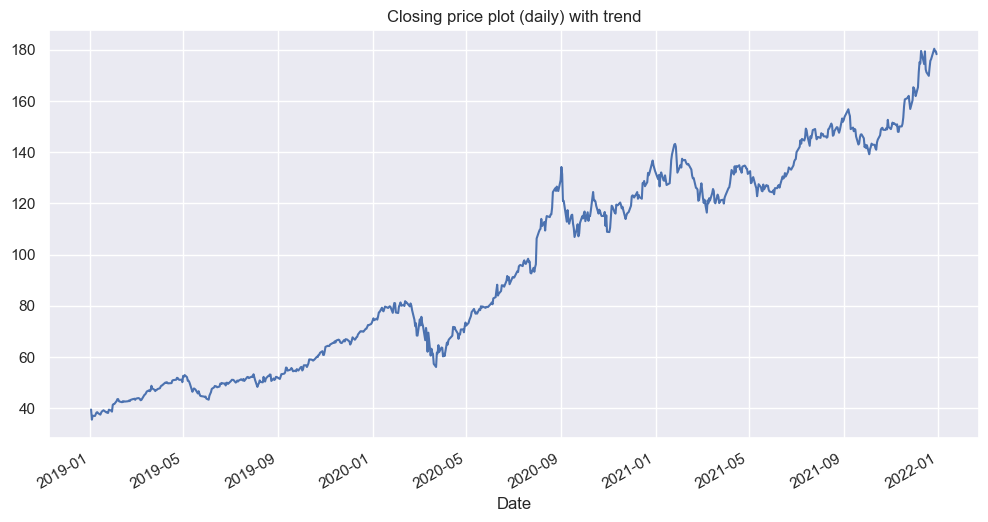

In [118]:
df["Close"].plot(title="Closing price plot (daily) with trend", figsize=(12, 6))

## Régression linéaire

Soit le vecteur $Y = (y_1, \dots, y_N)$ des prix de clôture du cours aux temps (ici, des jours) $1, \dots, N$.  

L'objectif est de s'ajuster aux données avec un modèle de régression linéaire simple donné par l'équation :
$$ Y = \beta_0 + \beta_1 * X$$
où $(\beta_0, \beta_1)$ est le vecteur des paramètres à estimer  
et $X = (1, \dots, N)$ est le vecteur <i>time dummy</i> qui représente l'avancement linéaire du temps.  

Puis il faut soustraire au vecteur de données originales $Y$ le vecteur des prédictions $Y_{pred}$ :
$$y_{detrend_i} = y_i - y_{pred_i} \hspace{12px} \forall i \in [1;N]$$ 

In [119]:
# Create deterministic process (X)

dp = DeterministicProcess(
    index=df.index,  # dates from the training data
    constant=True,  # dummy feature for the bias (y_intercept)
    order=1,  # order of the time dummy (trend)
    drop=False,  # drop terms if necessary to avoid collinearity
)

# `in_sample` creates features for the dates given in the `index` argument
X_dp = dp.in_sample()

X_dp

,const,trend
Date,,
2019-01-02,1.0,1.0
2019-01-03,1.0,2.0
2019-01-04,1.0,3.0
2019-01-07,1.0,4.0
2019-01-08,1.0,5.0
...,...,...
2021-12-23,1.0,752.0
2021-12-27,1.0,753.0
2021-12-28,1.0,754.0


In [120]:
# Convert data and fit the linear regression

X = np.array(X_dp)
y = np.array(df["Close"])

model = LinearRegression()
model.fit(X, y)

y_predict = model.predict(X)

Text(0.5, 1.0, 'Closing price and trend plot')

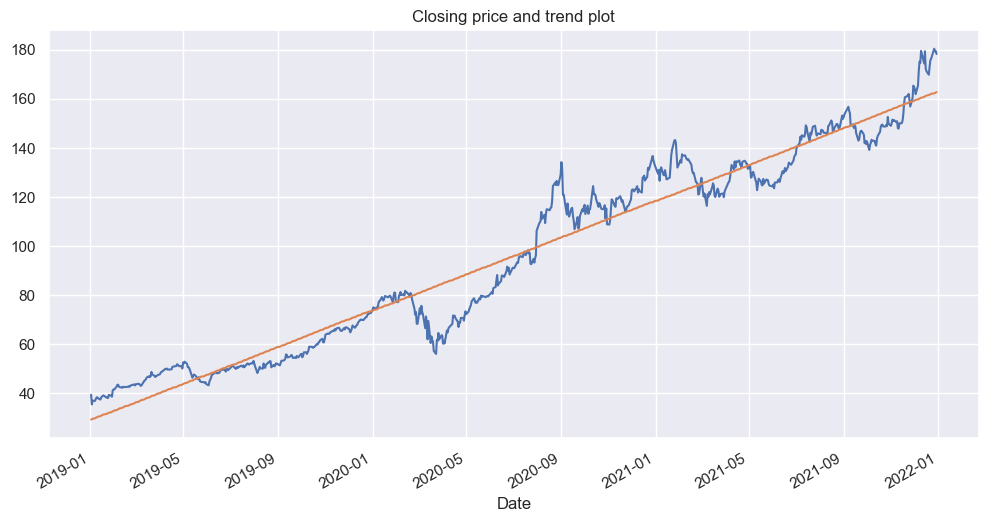

In [121]:
# Plot data and trend

_, ax = plt.subplots(figsize=(12, 6))

df["Close"].plot(ax=ax)
plt.plot(X_dp.index, y_predict)
plt.title("Closing price and trend plot")

<Axes: title={'center': 'Closing price without trend'}, xlabel='Date'>

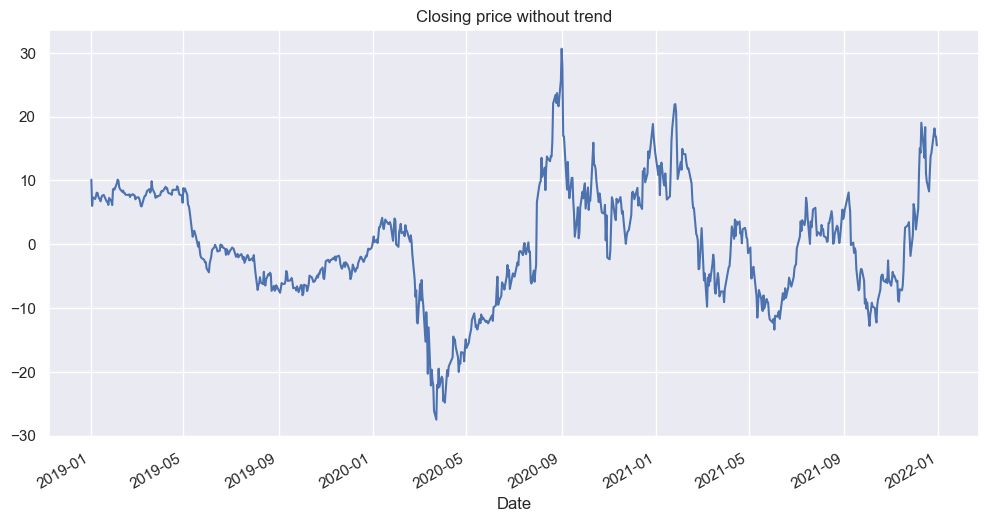

In [122]:
# substract the trend from the original times series

df["Close_detrend"] = df["Close"] - y_predict
df["Close_detrend"].plot(title="Closing price without trend", figsize=(12, 6))

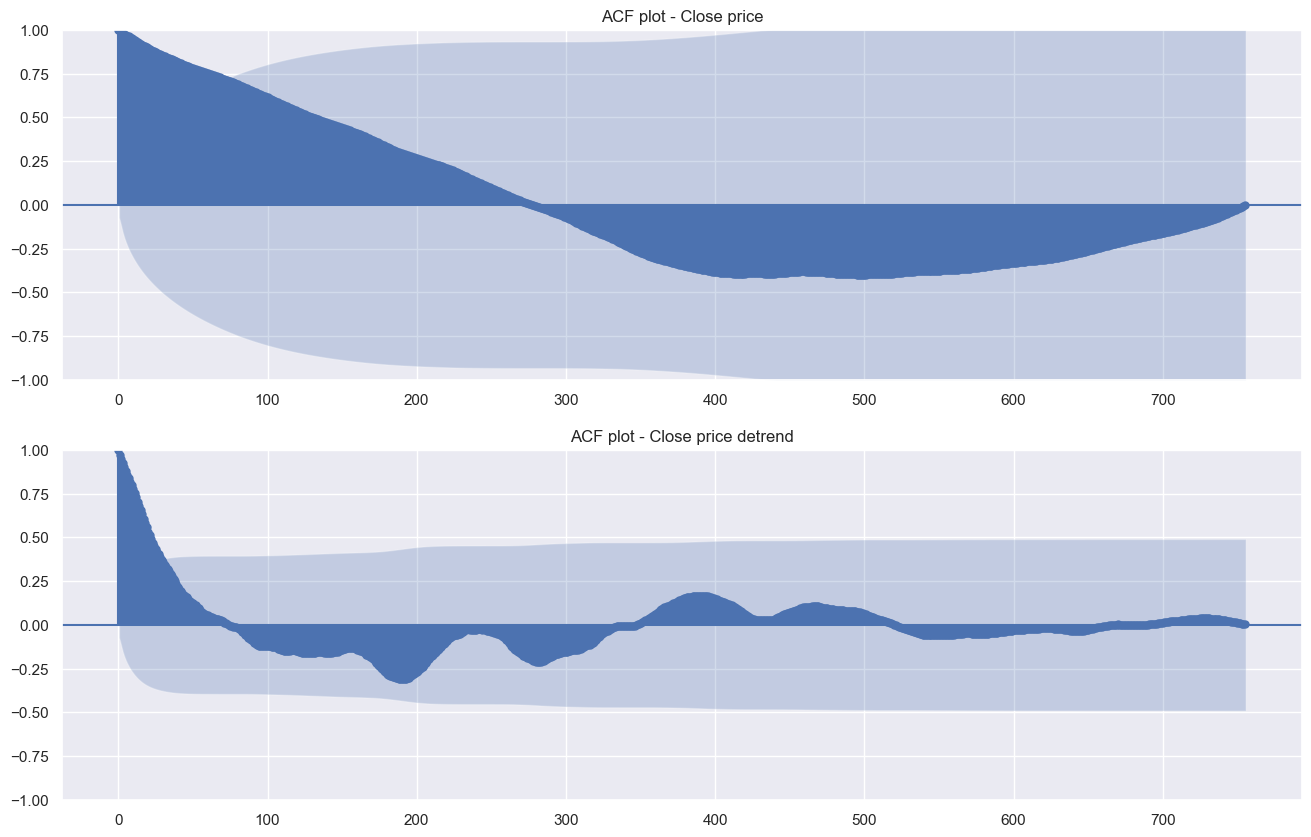

In [123]:
# acf plot before / after

lag = len(df) - 1

_, axs = plt.subplots(2, 1, figsize=(16, 10))
_ = plot_acf(df["Close"], ax=axs[0], lags=lag, title="ACF plot - Close price")
_ = plot_acf(
    df["Close_detrend"], ax=axs[1], lags=lag, title="ACF plot - Close price detrend"
)

- Les fortes autocorrélations dans le premier graphique montrent que la série temporelle contient une <b>tendance</b>.  
- Après déconstruction de la tendance, le deuxième graphique affiche cependant encore des autocorrélations importantes <b>pour des lags petits</b>. C'est un indice de <b>saisonnalité</b> ou de <b>cyclicité</b>. 

## Régression polynomiale par morceaux

Soit $k \in N^*$.  
Pour la régression polynomiale d'ordre $k$, le même principe que la régression linéaire simple est appliqué mais avec la particularité que des <i>time dummies</i> d'ordre $1, \dots, k$ sont ajoutées comme variables explicatives au modèle.  
L'équation de régression devient :
$$ Y = \sum_{i=0}^{k} \beta_i * X_i$$
où pour tout $i \in [1;k], \hspace{6px} X_i = (1^i, 2^i, \dots, N^i)$.
 
Cette méthode permet de capter une tendance polynomiale (croissante au carré du temps par exemple).

In [124]:
# Choix de l'ordre de la régression et du nombre de segments

order = 2
n_segments = 4

In [125]:
# Create deterministic process (X)

dp = DeterministicProcess(
    index=df.index,  # dates from the training data
    constant=True,  # dummy feature for the bias (y_intercept)
    order=order,  # order of the time dummy (trend)
    drop=False,  # drop terms if necessary to avoid collinearity
)

# `in_sample` creates features for the dates given in the `index` argument
X_dp = dp.in_sample()

X_dp

,const,trend,trend_squared
Date,,,
2019-01-02,1.0,1.0,1.0
2019-01-03,1.0,2.0,4.0
2019-01-04,1.0,3.0,9.0
2019-01-07,1.0,4.0,16.0
2019-01-08,1.0,5.0,25.0
...,...,...,...
2021-12-23,1.0,752.0,565504.0
2021-12-27,1.0,753.0,567009.0
2021-12-28,1.0,754.0,568516.0


In [126]:
# Convert data

X = np.array(X_dp)
y = np.array(df["Close"])

In [127]:
# Create segments

segment_length = len(y) // n_segments
y_segments = [y[i : i + segment_length] for i in range(0, len(y), segment_length)]
X_segments = [X[i : i + segment_length, :] for i in range(0, len(y), segment_length)]

In [128]:
# Fit and predict for each segment

y_pred_segments = np.array([])
for X_segment, y_segment in zip(X_segments, y_segments):
    model = LinearRegression()
    model.fit(X_segment, y_segment)
    y_pred_segment = model.predict(X_segment)
    y_pred_segments = np.append(y_pred_segments, y_pred_segment)

Text(0.5, 1.0, 'Closing price and trend plot')

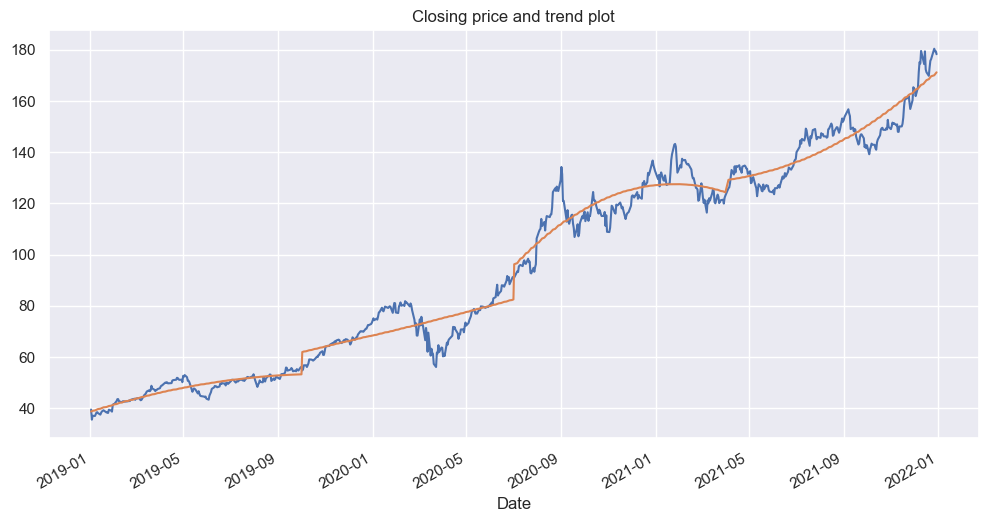

In [129]:
# Plot data and trend

_, ax = plt.subplots(figsize=(12, 6))

df["Close"].plot(ax=ax)
plt.plot(X_dp.index, y_pred_segments)
plt.title("Closing price and trend plot")

## Moyennes mobiles

### Linéaire

On se munit de $(x_t)_{t \in \mathbb{N}}$ une série temporelle.  

Soit $(k, t) \in \mathbb{N}^* \times \llbracket k~;~+\infty \rrbracket$,  
la moyenne mobile linéaire à gauche de profondeur $k$ pour $x_t$ est :
$$
ma_k(x_t) = \frac{\displaystyle \sum_{i=t-k+1}^{t}x_i}{k}
$$

In [130]:
# Create the linear mobile average for the data

linear_MA = df["Close"].rolling(center=True, window=100, min_periods=1).mean()

Text(0.5, 1.0, 'Closing price and trend plot')

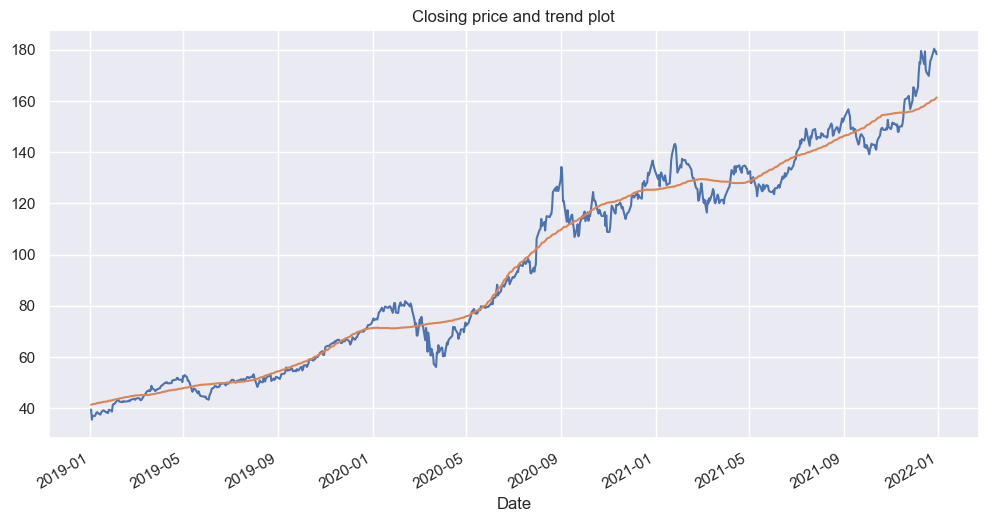

In [131]:
# Plot data and trend

_, ax = plt.subplots(figsize=(12, 6))

df["Close"].plot(ax=ax)
plt.plot(df.index, linear_MA)
plt.title("Closing price and trend plot")

### Exponentielle

La moyenne mobile exponentielle fait partie de la famille des moyennes mobiles pondérées.

On se munit de $(x_t)_{t \in \mathbb{N}}$ une série temporelle.  

Soit $t \in \mathbb{N}^*$ et $\alpha \in [0;1]$ une constante de lissage.
$$
\begin{align}
expma(x_{t})
    & = \alpha \left ( x_t + (1 - \alpha) x_{t - 1} + (1 - \alpha)^2 x_{t-2} + (1 - \alpha)^3 x_{t - 3} + \dots \right ) \\
    & = \displaystyle\sum_{n = 0}^{t} \alpha(1 - \alpha)^n x_{t - n}
\end{align}
$$

On remarque que la moyenne mobile exponentielle à l'instant $t$ prend en compte toutes les données qui précèdent. Toutefois, les valeurs très antérieures impactent très peu le résultat - d'autant plus que $\alpha$ est grand - et peuvent donc être négligées.

In [132]:
# Create the linear mobile average for the data

# in pandas documentation, decay = alpha
# decay can be chosen with optional span option in ewm method :
#   decay = 2 / (span + 1)
# or directly by specifying alpha = 0.05

expo_MA = df["Close"].ewm(alpha=0.05, adjust=False).mean()

Text(0.5, 1.0, 'Closing price and trend plot')

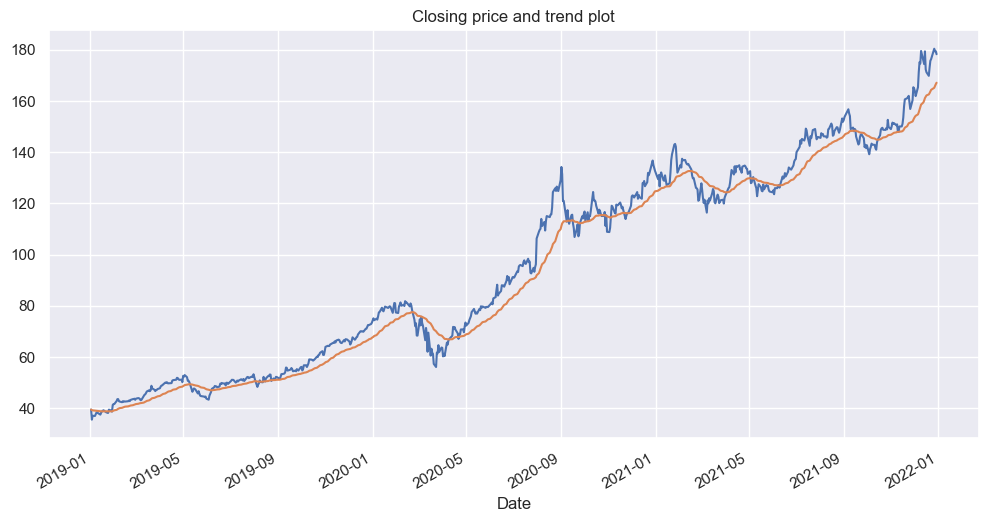

In [133]:
# Plot data and trend

_, ax = plt.subplots(figsize=(12, 6))

df["Close"].plot(ax=ax)
plt.plot(df.index, expo_MA)
plt.title("Closing price and trend plot")

## B-splines

In [134]:
# Define x and y

x = np.arange(len(df))  # time dummy, x
y = df["Close"]  # price, f(x)

In [135]:
# Define t the vector of knots,
# c the B-splines coefficients
# and k the degree of the splines

t, c, k = interpolate.splrep(x, y, s=10, k=3)  # s: smoothing factor
print("Length(t) =", len(t))
print("Length(c) =", len(c))
print("k =", k)

Length(t) = 613
Length(c) = 613
k = 3


In [136]:
# Interpolate the prices
spline = interpolate.BSpline(t, c, k, extrapolate=False)
y_interpolate = spline(x)

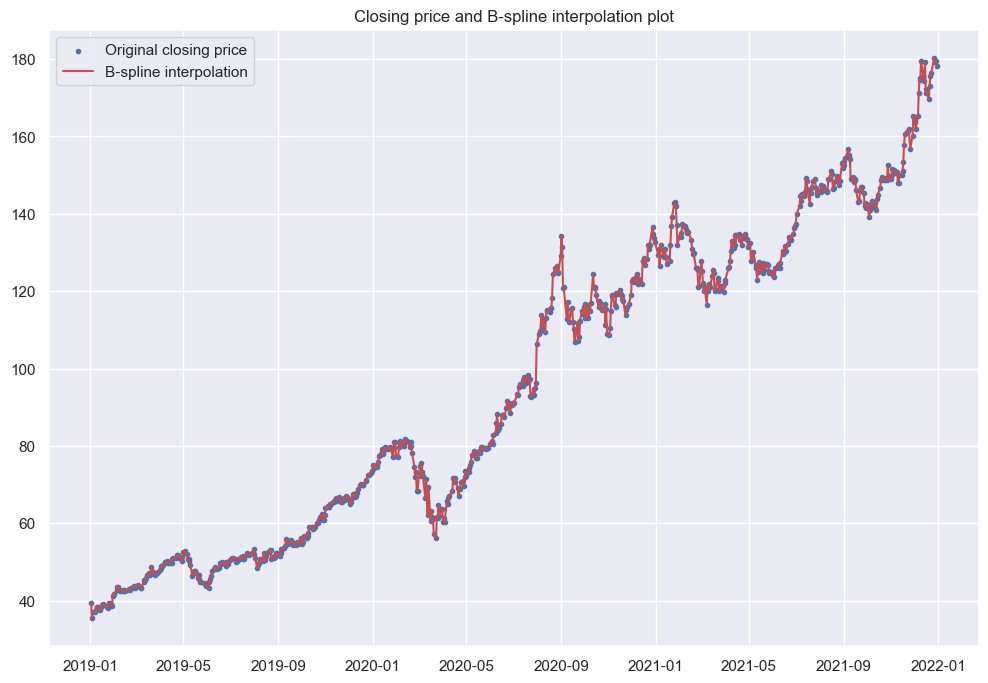

In [137]:
plt.figure(figsize=(12, 8))
plt.scatter(df.index, y, label="Original closing price", marker=".")
plt.plot(df.index, y_interpolate, "r", label="B-spline interpolation")
plt.legend(loc="best")
plt.title("Closing price and B-spline interpolation plot")
plt.show()

On obtient une courbe qui s'ajuste bien trop à nos données originales. On ne choisira donc pas cette option pour le detrending.

# Traitement de la saisonnalité

## Seasonality plot

In [138]:
# convert datetimeindex to periodindex in order to use .week method
# which doesnt exist for datetimeindex (wtf?)

df.index = df.index.to_period("D")
type(df.index)

pandas.core.indexes.period.PeriodIndex

In [139]:
# date features

df["day"] = df.index.day_of_week
df["week"] = df.index.week

In [140]:
# function got from https://github.com/Kaggle/learntools/blob/master/learntools/time_series/utils.py


def seasonal_plot(data: pd.DataFrame, series_to_plot: str, period, freq, ax=None):
    X = data
    y = series_to_plot

    if ax is None:
        _, ax = plt.subplots(figsize=(16, 8))
    palette = sns.color_palette(
        "husl",
        n_colors=X[period].nunique(),
    )
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    ax.set_xticks(range(5))  # 5 jours de la semaine
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
    ax.set_xticklabels(days)
    ax.set_xlabel("")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

C:\Users\jules\AppData\Local\Temp\ipykernel_10208\475151651.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


<Axes: title={'center': 'Seasonal Plot (week/day)'}, ylabel='Close_detrend'>

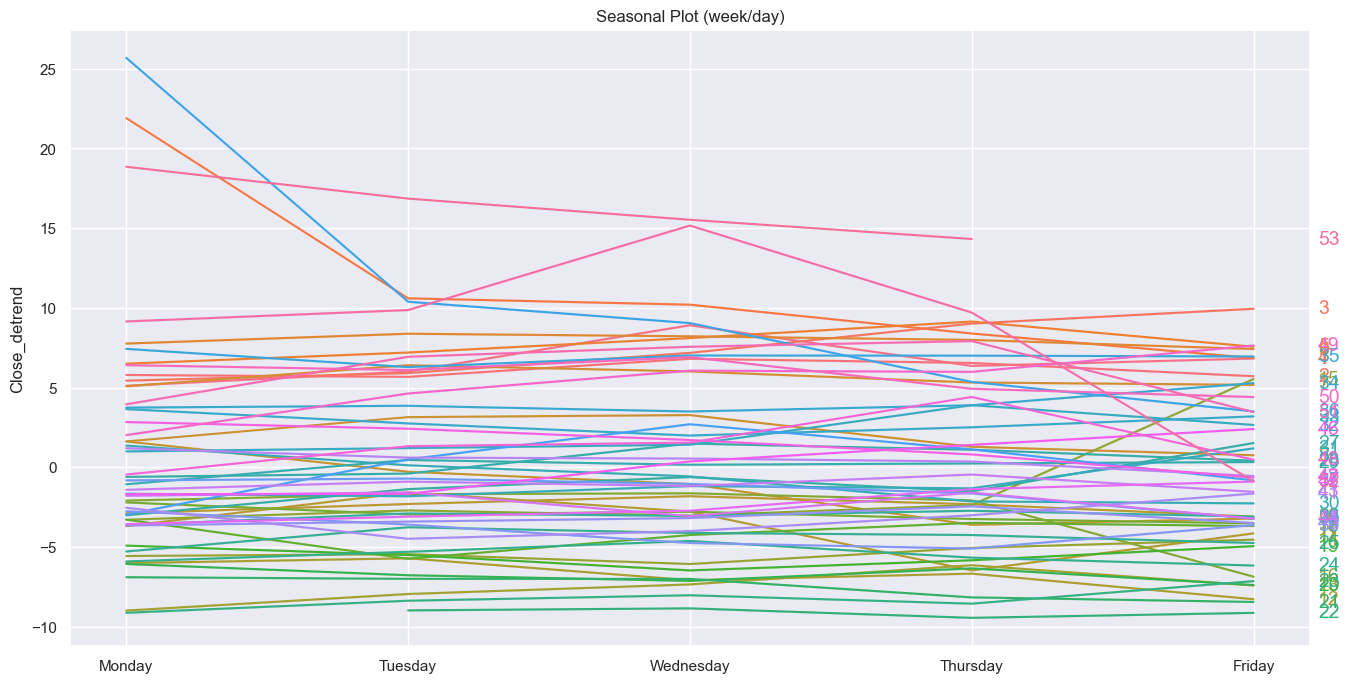

In [141]:
seasonal_plot(data=df, series_to_plot="Close_detrend", period="week", freq="day")

## Periodogram

In [151]:
# function got from https://github.com/Kaggle/learntools/blob/master/learntools/time_series/utils.py


def plot_periodogram(time_series: pd.Series, detrend="linear", ax=None):
    from scipy.signal import periodogram

    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        time_series,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling="spectrum",
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(16, 8))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

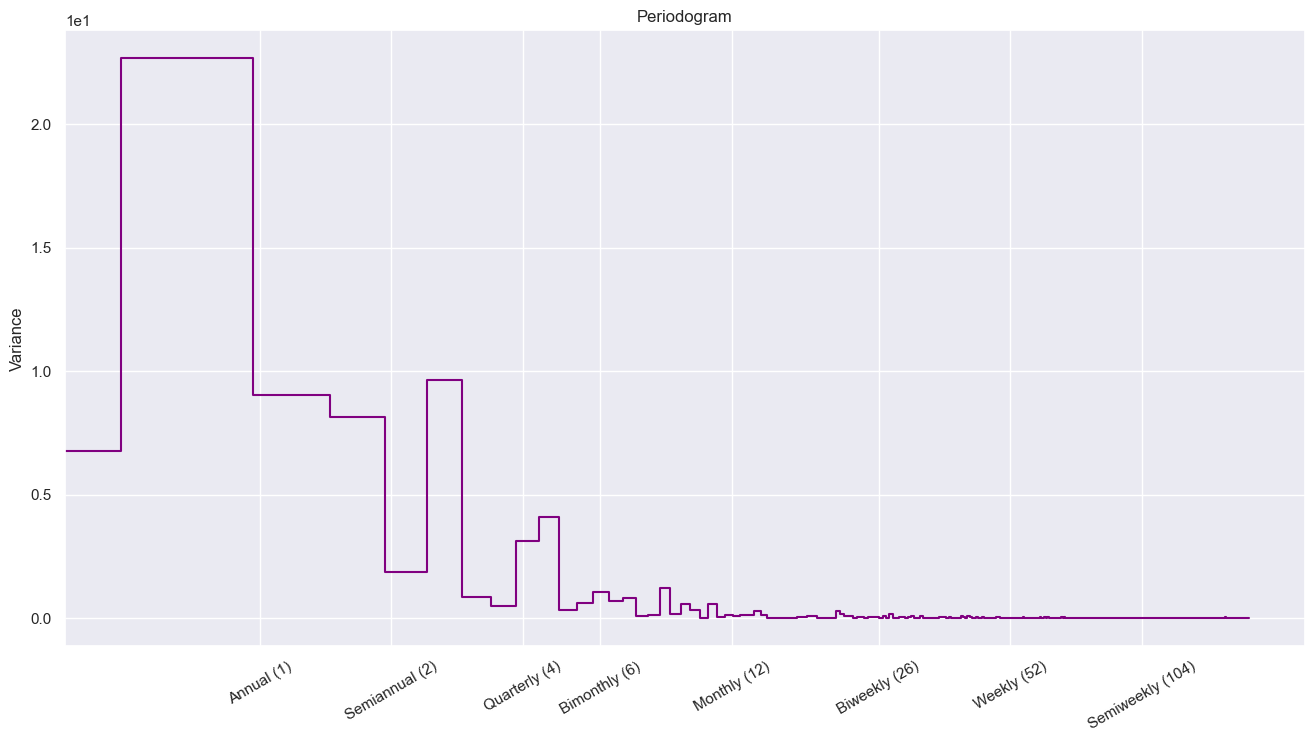

In [152]:
plot_periodogram(time_series=df["Close_detrend"])